In [1]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

root_dir = "../../"
sys.path.append(root_dir)

from dataset import CTICHDataset
from utils import models, location_performance_t, find_hemorrhages

data_dir = os.path.join(root_dir, "data")
ctich_dir = os.path.join(data_dir, "CT-ICH")
prediction_dir = os.path.join(ctich_dir, "predictions")
figure_dir = os.path.join(root_dir, "figures", "exam_level")
os.makedirs(figure_dir, exist_ok=True)

sns.set_theme()
sns.set_context("paper", font_scale=1.5)

In [2]:
dataset = CTICHDataset(ctich_dir)

true_hemorrhage = []
for data in tqdm(dataset):
    _, _, labels = data

    _true_hemorrhage = find_hemorrhages(labels)
    if len(_true_hemorrhage) > 0:
        true_hemorrhage.extend([len(hem) for hem in _true_hemorrhage])
true_hemorrhage = np.array(true_hemorrhage)
print(
    f"{len(true_hemorrhage)} hemorrhages, {int(true_hemorrhage.mean())} images +- {int(true_hemorrhage.std())}"
)

100%|██████████| 75/75 [01:30<00:00,  1.21s/it]

45 hemorrhages, 7 images +- 4


In [12]:
def exam_level_tpr(cutoff):
    cutoff_method, cutoff_name = cutoff

    df = []
    for model_title, model, weak_supervision in tqdm(models):
        prediction_df = pd.read_pickle(
            os.path.join(prediction_dir, model, "predictions")
        )
        prediction_df.set_index("series_idx", inplace=True)

        _df = location_performance_t(
            model_title,
            prediction_df,
            weak_supervision,
            cutoff=cutoff_method,
        )
        df.append(_df)
    df = pd.concat(df)
    df = df.explode(["true_hemorrhage_length", "hit"])

    res = []
    df = df.groupby(["est_name"])
    for name, group in df:
        values = group["hit"].dropna().values
        values = (values,)
        res.append((name, scipy.stats.bootstrap(values, np.mean, n_resamples=100)))

    _, ax = plt.subplots()
    ax.hist(res[0][1].bootstrap_distribution.astype(float), bins=20, alpha=0.5)
    ax.hist(res[1][1].bootstrap_distribution.astype(float), bins=20, alpha=0.5)
    plt.show()

    _, ax = plt.subplots()
    ax.hist(res[0][1].bootstrap_distribution.astype(float), bins=20, alpha=0.5)
    ax.hist(res[2][1].bootstrap_distribution.astype(float), bins=20, alpha=0.5)
    plt.show()

    print(
        np.mean(res[0][1].bootstrap_distribution.astype(float)),
        np.mean(res[1][1].bootstrap_distribution.astype(float)),
    )
    p1 = scipy.stats.ttest_ind(
        res[0][1].bootstrap_distribution.astype(float),
        res[1][1].bootstrap_distribution.astype(float),
        alternative="less",
    )
    print(p1)
    p2 = scipy.stats.ttest_ind(
        res[0][1].bootstrap_distribution.astype(float),
        res[2][1].bootstrap_distribution.astype(float),
        alternative="less",
    )
    print(p2)
    raise NotImplementedError

    _, ax = plt.subplots(figsize=(16 / 2, 9 / 2))
    bar = sns.barplot(data=df, x="est_name", y="hit", ax=ax)
    container = bar.containers[0]
    print(container.datavalues, container.errorbar)
    ax.set_xlabel("")
    ax.set_ylabel("TPR")
    ax.set_ylim(0, 1)
    ax.set_title(cutoff_name)

    plt.savefig(
        os.path.join(figure_dir, f"CT-ICH_TPR_{cutoff_method}.jpg"), bbox_inches="tight"
    )
    plt.savefig(
        os.path.join(figure_dir, f"CT-ICH_TPR_{cutoff_method}.pdf"), bbox_inches="tight"
    )
    plt.show()
    plt.close()

100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


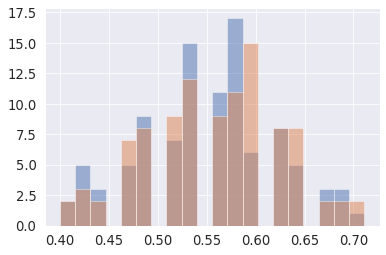

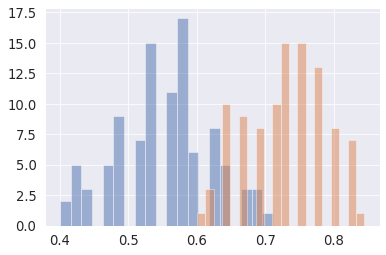

0.5506666666666666 0.5575555555555556
Ttest_indResult(statistic=-0.6975366612709124, pvalue=0.24314263385916413)
Ttest_indResult(statistic=-19.775273384496984, pvalue=4.611576454639606e-49)


NotImplementedError: 

In [13]:
cutoffs = [("youden", r"Youden's $J$ statistic"), ("d", r"Distance to $(0,1)$ point")]
for cutoff in cutoffs:
    exam_level_tpr(cutoff)